### **AutoEncoder with Pytorch**

### **What is AutoEncoder?**
- AutoEncoder is type of Neural Network utilized to extract efficient features from unlabel data. It is Unsupervised Deep learning Architecture.
- AutoEncoder is used to learn compresssed representation of data that used to learn to reconstruct the images from latent code space.
- AutoEncoders obtains the latent code from a **Encoder Network**.
- AutoEncoder Obtain the latent code as input to the **Decoder Network**, which tries to reconstruct the images that network has been trained on.
> _“**Autoencoding** is a data compression algorithm where the compression and decompression functions are 
1) data-specific, 
2) lossy, and 
3) learned automatically from examples rather than engineered by a human."_
--  _Keras Blog_

![](https://debuggercafe.com/wp-content/uploads/2019/12/autoencoder_nn-1-e1577235910280.png)

### **Principal Behind AutoEncoder**
- It Contains two part **Encoder** and **Decoder**.
1. Encoder takes the input(x) and encodes($f(x)$) it.
$$ r = f(x) $$
2. Hidden Layer is work as bridge between **Encoder** and **Decoder**.
$$ h = g(f(x)) $$
3. Decoder tries to reconstruct the input data from hidden layer coding Decoding function($G$).
$$ r = g(h) $$

Dataset: FashionMNIST  
* **Train Images** : 60000   
* **Test Images** : 10000  
* **Classes** : 0: Tshirt/Top, 1: trouser, 2:pullover, 3:dress, 4:coat, 5: sandal, 6:shirt, 7: sneaker, 8: bag, 9:ankle boot  
### **1. Load Libraries** 

Some of the important imports include:

* `torchvision`: contains many popular computer vision datasets, deep neural network architectures, and image processing modules. We will use this to download the Fashion MNIST and in later articles the CIFAR10 dataset as well.
* `torch.nn`: contains the deep learning neural network layers such as `Linear()`, and `Conv2d()`.
* `transforms`: will help in defining the image transforms and normalizations.
* `optim`: contains the deep learning optimizer classes such as `MSELoss()` and many others as well.
* `functional`: we will use this for activation functions such as ReLU.
* `DataLoader`: eases the task of making iterable training and testing sets.

In [1]:
# torch loaded...!!!
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

# torchvision loaded...!!!
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchsummary import summary

# other libraries loaded...!!!
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

### **2.Define the Constants**

In [2]:
# constants
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 128

# image tranformation
transform = transforms.Compose([transforms.ToTensor(),])

### **3.Download dataset and Load into DataLoader**

- The `trainloader` and `testloader` each is of batch size `128`. The data loaders are iterable and you will be a1ble to iterate through them till the number of batches in them. Specifically, the `trainloader` contains `60000/128` number of batches, and the `testloader` contains `10000/128` number of batches.

In [3]:
trainset = datasets.FashionMNIST(root="./data_new", train=True, transform=transform, download=True)
testset = datasets.FashionMNIST(root="./data_new", train=False, transform=transform, download=True)

trainLoader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testLoader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

26422272it [00:05, 4830894.61it/s]                              


Extracting ./data_new\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data_new\FashionMNIST\raw



29696it [00:00, 216241.55it/s]                          


Extracting ./data_new\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data_new\FashionMNIST\raw



4422656it [00:01, 2943952.24it/s]                             


Extracting ./data_new\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data_new\FashionMNIST\raw



6144it [00:00, 6175366.35it/s]          

Extracting ./data_new\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data_new\FashionMNIST\raw




C:\Users\SHIVA\miniconda3\envs\pytorch19\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### **4.Utility Function**

- The first function, `get_device()` either `returns the GPU device` if it is available or the `CPU`. If you notice, this is a bit different from the one-liner code used in the PyTorch tutorials. This is because some IDEs do not recognize the `torch.device()` method. Therefore, to keep the code compatible for both IDE and python notebooks I just changed the code a bit.

- The second function is `make_dir()` which makes a directory to store the reconstructed images while training. At last, we have `save_decoded_image()` which saves the images that the autoencoder reconstructs.

In [4]:
# utility functions
def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
    else:
        device = torch.device("cpu")
    return device

# make dir
def make_dir():
    image_dir = "./FashionMNIST_Images"
    if not os.path.exists(image_dir):
        os.mkdir(image_dir)
        
# save decoded images
def save_decoded_image(img, epoch):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, "./FashionMNIST_Images/epoch_" + str(epoch) + ".png")


### **5.Define AutoEncoder**

In [5]:
    
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        # encoder
        self.efc1 = nn.Linear(784, 256)
        self.efc2 = nn.Linear(256, 128)
        self.efc3 = nn.Linear(128, 64)
        self.efc4 = nn.Linear(64, 32)
        self.efc5 = nn.Linear(32, 16)
        
        # decoder
        self.dec1 = nn.Linear(16, 32)
        self.dec2 = nn.Linear(32, 64)
        self.dec3 = nn.Linear(64, 128)
        self.dec4 = nn.Linear(128, 256)
        self.dec5 = nn.Linear(256, 784)
        
    def forward(self, x):
        # Encoder Module
        x = F.relu(self.efc1(x))
        x = F.relu(self.efc2(x))
        x = F.relu(self.efc3(x))
        x = F.relu(self.efc4(x))
        x = F.relu(self.efc5(x))
        
        # Decoder Module
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x))
        return x
        

In [6]:
net = AutoEncoder()
net.to(get_device())     

AutoEncoder(
  (efc1): Linear(in_features=784, out_features=256, bias=True)
  (efc2): Linear(in_features=256, out_features=128, bias=True)
  (efc3): Linear(in_features=128, out_features=64, bias=True)
  (efc4): Linear(in_features=64, out_features=32, bias=True)
  (efc5): Linear(in_features=32, out_features=16, bias=True)
  (dec1): Linear(in_features=16, out_features=32, bias=True)
  (dec2): Linear(in_features=32, out_features=64, bias=True)
  (dec3): Linear(in_features=64, out_features=128, bias=True)
  (dec4): Linear(in_features=128, out_features=256, bias=True)
  (dec5): Linear(in_features=256, out_features=784, bias=True)
)

In [7]:
summary(net, (784, ))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 256]                 200,960
├─Linear: 1-2                            [-1, 128]                 32,896
├─Linear: 1-3                            [-1, 64]                  8,256
├─Linear: 1-4                            [-1, 32]                  2,080
├─Linear: 1-5                            [-1, 16]                  528
├─Linear: 1-6                            [-1, 32]                  544
├─Linear: 1-7                            [-1, 64]                  2,112
├─Linear: 1-8                            [-1, 128]                 8,320
├─Linear: 1-9                            [-1, 256]                 33,024
├─Linear: 1-10                           [-1, 784]                 201,488
Total params: 490,208
Trainable params: 490,208
Non-trainable params: 0
Total mult-adds (M): 0.49
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.87
Estimated To

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 256]                 200,960
├─Linear: 1-2                            [-1, 128]                 32,896
├─Linear: 1-3                            [-1, 64]                  8,256
├─Linear: 1-4                            [-1, 32]                  2,080
├─Linear: 1-5                            [-1, 16]                  528
├─Linear: 1-6                            [-1, 32]                  544
├─Linear: 1-7                            [-1, 64]                  2,112
├─Linear: 1-8                            [-1, 128]                 8,320
├─Linear: 1-9                            [-1, 256]                 33,024
├─Linear: 1-10                           [-1, 784]                 201,488
Total params: 490,208
Trainable params: 490,208
Non-trainable params: 0
Total mult-adds (M): 0.49
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.87
Estimated To

### **6. Loss function and Optimizer**

In [8]:
# Loss function
loss_fn = nn.MSELoss()

# Optimizer function
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

### **7.Train and Test Function**

In [9]:
def train(net, trainloader, NUM_EPOCHS):
    train_loss = []
    s_t = time.time()
    for epoch in range(NUM_EPOCHS):
        start = time.time()
        running_loss = 0.0
        for data in trainloader:
            img, _ = data
            img = img.to(device)
            img = img.view(img.size(0), -1)
            optimizer.zero_grad()
            outputs = net(img)
            loss = loss_fn(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        end = time.time()
        total_time = end - start
        print('Epoch {} of {}, ETA : {:.2f} Seconds, Train Loss: {:.3f}'.format(
                epoch+1, NUM_EPOCHS, total_time, loss))
        if epoch % 5 == 0:
            save_decoded_image(outputs.cpu().data, epoch)
    e_t = time.time()
    print("Total time : {:.2f} Minutes".format((e_t - s_t)/60))
    return train_loss

def test_image_reconstruction(net, testloader):
     for batch in testloader:
        img, _ = batch
        img = img.to(device)
        img = img.view(img.size(0), -1)
        outputs = net(img)
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        save_image(outputs, 'fashionmnist_reconstruction.png')
        break

### **8.Train AutoEncoder**

cuda:0
Epoch 1 of 50, ETA : 9.83 Seconds, Train Loss: 0.074
Epoch 2 of 50, ETA : 10.03 Seconds, Train Loss: 0.041
Epoch 3 of 50, ETA : 9.62 Seconds, Train Loss: 0.033
Epoch 4 of 50, ETA : 9.69 Seconds, Train Loss: 0.029
Epoch 5 of 50, ETA : 9.77 Seconds, Train Loss: 0.028
Epoch 6 of 50, ETA : 9.75 Seconds, Train Loss: 0.026
Epoch 7 of 50, ETA : 9.82 Seconds, Train Loss: 0.025
Epoch 8 of 50, ETA : 10.04 Seconds, Train Loss: 0.024
Epoch 9 of 50, ETA : 9.74 Seconds, Train Loss: 0.023
Epoch 10 of 50, ETA : 9.72 Seconds, Train Loss: 0.023
Epoch 11 of 50, ETA : 9.75 Seconds, Train Loss: 0.022
Epoch 12 of 50, ETA : 9.75 Seconds, Train Loss: 0.022
Epoch 13 of 50, ETA : 9.71 Seconds, Train Loss: 0.021
Epoch 14 of 50, ETA : 12.85 Seconds, Train Loss: 0.021
Epoch 15 of 50, ETA : 8673.00 Seconds, Train Loss: 0.021
Epoch 16 of 50, ETA : 29.05 Seconds, Train Loss: 0.021
Epoch 17 of 50, ETA : 27.66 Seconds, Train Loss: 0.020
Epoch 18 of 50, ETA : 19.47 Seconds, Train Loss: 0.020
Epoch 19 of 50, ETA :

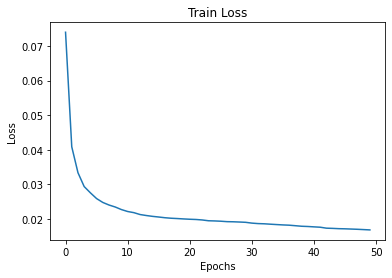

In [10]:
# get the computation device
device = get_device()
print(device)

# load the neural network onto the device
net.to(device)
make_dir()

# train the network
train_loss = train(net, trainLoader, NUM_EPOCHS)
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('deep_ae_fashionmnist_loss.png')

# test the network
test_image_reconstruction(net, testLoader)